In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

In [25]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics 
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
trainset = pd.read_csv('Data\credit_card_default_train.csv', index_col='Client_ID' )
testset = pd.read_csv('Data\credit_card_default_test.csv', index_col='Client_ID' )

In [3]:
trainset['Balance_Limit_V1'] = trainset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)
testset['Balance_Limit_V1'] = testset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

In [4]:
testset = testset.sort_values('Client_ID')

In [5]:
target = 'NEXT_MONTH_DEFAULT'

IDcol = 'Client_ID'

predictors = [x for x in trainset.columns if x not in [target, IDcol]]

cate_features_name = ["Gender","EDUCATION_STATUS","MARITAL_STATUS","AGE",'PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']

In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, A2 to A30000
Data columns (total 24 columns):
Balance_Limit_V1      24000 non-null int32
Gender                24000 non-null object
EDUCATION_STATUS      24000 non-null object
MARITAL_STATUS        24000 non-null object
AGE                   24000 non-null object
PAY_JULY              24000 non-null int64
PAY_AUG               24000 non-null int64
PAY_SEP               24000 non-null int64
PAY_OCT               24000 non-null int64
PAY_NOV               24000 non-null int64
PAY_DEC               24000 non-null int64
DUE_AMT_JULY          24000 non-null int64
DUE_AMT_AUG           24000 non-null int64
DUE_AMT_SEP           24000 non-null int64
DUE_AMT_OCT           24000 non-null int64
DUE_AMT_NOV           24000 non-null int64
DUE_AMT_DEC           24000 non-null int64
PAID_AMT_JULY         24000 non-null int64
PAID_AMT_AUG          24000 non-null int64
PAID_AMT_SEP          24000 non-null int64
PAID_AMT_OCT          24000 no

In [10]:
#Ordinal Encoding
encode_columns = ['AGE']
encode_df = trainset[encode_columns]
encode_df = encode_df.astype('str')
le = LabelEncoder()
encode_df = encode_df.apply(le.fit_transform)
score_encode_drop = trainset.drop(encode_columns, axis = 1)
score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)

encode_df_test = testset[encode_columns]
encode_df_test = encode_df_test.astype('str')
encode_df_test = encode_df_test.apply(le.fit_transform)
score_encode_drop_test = testset.drop(encode_columns, axis = 1)
score_encode_test = pd.concat([score_encode_drop_test, encode_df_test], axis = 1)
#OneHot Encoding
onehot_columns =  ['MARITAL_STATUS', 'EDUCATION_STATUS', 'Gender']
onehot_df = score_encode[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns)
score_onehot_drop = score_encode.drop(onehot_columns, axis = 1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis = 1)

onehot_df_test = score_encode_test[onehot_columns]
onehot_df_test = pd.get_dummies(onehot_df_test, columns = onehot_columns)
score_onehot_drop_test = score_encode_test.drop(onehot_columns, axis = 1)
score_onehot_test = pd.concat([score_onehot_drop_test, onehot_df_test], axis = 1)

In [11]:
New = score_onehot.drop(['Gender_M', 'MARITAL_STATUS_Other','Gender_F','EDUCATION_STATUS_Other','EDUCATION_STATUS_High School','EDUCATION_STATUS_Graduate','MARITAL_STATUS_Single','AGE'], axis=1)

In [17]:
train_all, test_all = train_test_split(New, test_size=0.30, random_state=42, stratify = trainset[target])

In [13]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['NEXT_MONTH_DEFAULT'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['NEXT_MONTH_DEFAULT'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['NEXT_MONTH_DEFAULT'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return alg


Model Report
Accuracy : 0.8662
AUC Score (Train): 0.902284


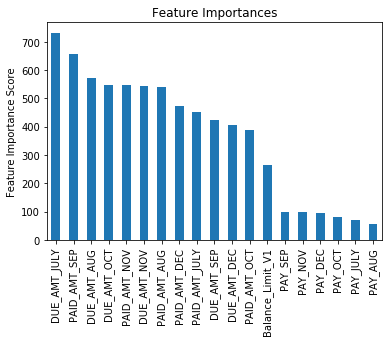

In [18]:
predictorsnew = [x for x in New.columns if x not in [target, IDcol]]
xgb_new = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_2 = modelfit(xgb_new, New, predictorsnew)

In [20]:
def f1score(m, train, test, predictorsnew): 
    predictions_lgbm_01 = np.where(m.predict(train[predictorsnew]) > 0.5, 1, 0)
    predictions_lgbm_02 = np.where(m.predict(test[predictorsnew]) > 0.5, 1, 0)
    return (f1_score(train[target],predictions_lgbm_01),f1_score(test[target],predictions_lgbm_02))

In [21]:
f1score(model_2,train_all, test_all, predictorsnew)

(0.6066481994459834, 0.6223832528180354)

<Figure size 432x288 with 0 Axes>

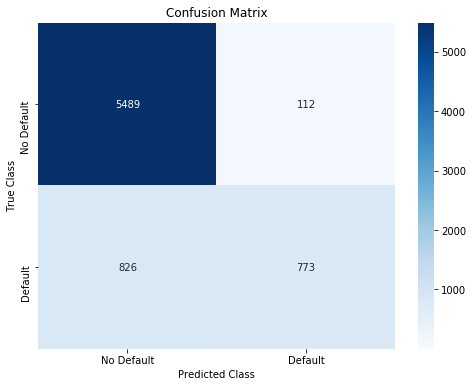

In [24]:
#Print Confusion Matrix
predictions_lgbm_02 = np.where(model_2.predict(test_all[predictorsnew]) > 0.5, 1, 0)

plt.figure()
cm = confusion_matrix(test_all[target], predictions_lgbm_02)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Parameter Tuning

In [36]:
# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "gpu_exact", predictor = "gpu_predictor", eval_metric = ["error", "auc"], objective = "binary:logistic")

# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "roc_auc", cv = 10, verbose = 3, random_state = 40 )

In [ ]:
# Fit the model
model_xgboost = xgb_rscv.fit(train_all[predictorsnew], train_all[target])

In [ ]:
# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

In [ ]:
predictorsnew = [x for x in New.columns if x not in [target, IDcol]]
xgb_new = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_2 = modelfit(xgb_new, New, predictorsnew)

In [ ]:
f1score(model_2,train_all, test_all, predictorsnew)

In [ ]:
#Print Confusion Matrix
predictions_lgbm_02 = np.where(model_2.predict(test_all[predictorsnew]) > 0.5, 1, 0)

plt.figure()
cm = confusion_matrix(test_all[target], predictions_lgbm_02)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
pd.DataFrame(model_2.predict(score_onehot_test[predictorsnew])).to_csv('sumbission_day3.csv')